In [1]:
!pip install -Uqqq pycocotools

In [5]:
!pip install tqdm

     |████████████████████████████████| 78 kB 7.3 MB/s  eta 0:00:01


In [1]:
import cv2
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from pycocotools.coco import COCO

from pathlib import Path
from PIL import Image

from itertools import groupby
from skimage import io
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import pycocotools.mask as mask_util

In [2]:
df = pd.read_csv('/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection/train.csv')
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
def rle_decode(mask_rle, shape):
    """
    Decodes run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    :param rle_mask (str): Run-length encoded segmentation mask string.
    :param shape (tuple): (height, width) of array to return
    :return mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """
    # Splits the RLE string into a list of string by whitespaces.
    s = mask_rle.split()
    
    # This creates two numpy arrays, one with the RLE starts and one with their respective lengths
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    
    # To obtain the end point we need to substract 1 to the length or start because the initial point counts.
    starts -= 1
    ends = starts + lengths
    
    # Create a 1D array of size H*W of zeros
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    # Fill this array with ones in the positions where there is a mask using the RLE information
    for start, end in zip(starts, ends):
        mask[start:end] = 1
    
    # Reshape the 1D array into a 2D array so we can finally get the binary 2D mask.
    mask = mask.reshape(shape)
    return mask.T


def binary_mask_to_rle(binary_mask):
    """
    Checkout: https://cocodataset.org/#format-results
    :param mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    
    This function returns the following dictionary:
    {
        "counts": encoded mask suggested by the official COCO dataset webpage.
        "size": the size of the input mask/image
    }
    """
    # Create dictionary for the segmentation key in the COCO dataset
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    # We need to convert it to a Fortran array
    binary_mask_fortran = np.asfortranarray(binary_mask)
    # Encode the mask as specified by the official COCO format
    encoded_mask = mask_util.encode(binary_mask_fortran)
    # We must decode the byte encoded string or otherwise we cannot save it as a JSON file
    rle["counts"] = encoded_mask["counts"].decode()
    return rle



29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5


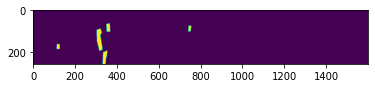

In [4]:
rle = df.loc[0, 'EncodedPixels']
print(rle)
plt.imshow(rle_decode(rle, (1600, 256)))

In [5]:

def create_coco_format_json(data_frame, classes, filepaths):
    """
    This function creates a COCO dataset.
    :param data_frame: pandas dataframe with an "id" column.
    :param classes: list of strings where each string is a class.
    :param filepaths: a list of strings containing all images paths
    :return dataset_coco_format: COCO dataset (JSON).
    """
    images = []
    annotations = []
    categories = []
    count = 0
    
    # Creates a categories list, i.e: [{'id': 0, 'name': 'a'}, {'id': 1, 'name': 'b'}, {'id': 2, 'name': 'c'}] 
    for idx, class_ in enumerate(classes):
        categories.append(
            { 
                "id": class_,
                "name": f'class_{class_}'
            }
        )
    
    # Iterate over image filepaths
    for filepath in tqdm(filepaths):
        # Get the image id, e.g: "10044"
        #print(filepath)
        file_id = filepath.split("/")[-1]
        #print(file_id)
        # Get the image height, e.g: 360 (px)
        height = 1600
        # Get the image width, e.g: 310 (px)
        width = 256
        # One image has many annotations associated to it (1 for each class), get a list with the indices.
        ids = data_frame.index[data_frame['ImageId'] == file_id].tolist()
        #print(ids)
        # Get filename
        file_name = filepath.split("/")[-1]
        
        
        
        if (len(ids) > 0):
            # Adding images which has annotations
            images.append(
                {
                    "id": file_id,
                    "width": width,
                    "height": height,
                    "file_name": file_name
                }
            )
            for idx in ids:
                # Convert the RLE string into a numpy array binary mask
                mk = rle_decode(data_frame.iloc[idx]['EncodedPixels'], (height, width))
                ys, xs = np.where(mk)
                x1, x2 = min(xs), max(xs)
                y1, y2 = min(ys), max(ys)
                """
                Contours can be explained simply as a curve joining all the continuous points (along the boundary),
                having same color or intensity. The function retrieves contours from the binary image using the
                algorithm specified in the function. One RLE segmentation for a single class may have disconnected
                shapes, like "spots". We will iterate over these "spots" thus creating a new image for each spot.
                This image will be temporary, it will help us create annotations for each of these "spots".
                """
                contours, hierarchy = cv2.findContours(mk,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
                
                for id_, contour in enumerate(contours):
                    # Image with 3 channels where H and W remain the same.
                    mask_image = np.zeros((mk.shape[0], mk.shape[1], 3),  np.uint8)
                    # This function takes the image and fills the contour inside it.
                    cv2.drawContours(mask_image, [contour], -1, (255,255,255), thickness=cv2.FILLED)
                    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
                    mask_image_bool = np.array(mask_image, dtype=bool).astype(np.uint8)
                    ys, xs = np.where(mask_image_bool)
                    x1, x2 = min(xs), max(xs)
                    y1, y2 = min(ys), max(ys)
                    enc = binary_mask_to_rle(mask_image_bool)
                    seg = {
                        'segmentation': enc, 
                        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
                        'area': int(np.sum(mask_image_bool)),
                        'image_id':file_id, 
                        'category_id':classes.index(data_frame.iloc[idx]['ClassId']), 
                        'iscrowd':0, 
                        'id': count
                    }
                    annotations.append(seg)
                    count +=1
            
    # Create the dataset
    dataset_coco_format = {
        "categories": categories,
        "images": images,
        "annotations": annotations,
    }
    
    return dataset_coco_format


def sep():
    print("-"*100)

In [11]:
# Setting the paths.
DATASET_PATH = "/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection"
IMAGE_DIR = DATASET_PATH + "train_images/"
TRAIN_CSV_PATH = DATASET_PATH + "train.csv"

In [14]:
# Set classes
classes = df["ClassId"].unique().tolist()

# Get list with all image file paths
filepaths = list()
for (dirpath, dirnames, filenames) in os.walk(DATASET_PATH):
    filepaths += [os.path.join(dirpath, file) for file in filenames if file.endswith(".jpg")]
    
filepaths_train = filepaths[:-1]
filepaths_test = [filepaths[-1]]
# Create COCO Datasets
train_json = create_coco_format_json(df, classes, filepaths_train)

100%|██████████| 43973/43973 [14:59<00:00, 48.86it/s] 


In [56]:
# Setting the paths.
DATASET_PATH = "/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection"
IMAGE_DIR = DATASET_PATH + "val26/"
TRAIN_CSV_PATH = DATASET_PATH + "val26.csv"

In [57]:
# Set classes
classes = df["ClassId"].unique().tolist()

# Get list with all image file paths
filepaths = list()
for (dirpath, dirnames, filenames) in os.walk(DATASET_PATH):
    filepaths += [os.path.join(dirpath, file) for file in filenames if file.endswith(".jpg")]

filepaths_train = filepaths[:-1]
filepaths_test = [filepaths[-1]]
# Create COCO Datasets
val_json = create_coco_format_json(va, classes, filepaths_train)

100%|██████████| 44114/44114 [01:46<00:00, 414.80it/s] 


In [48]:
train_json['images'][1]

{'id': 'c51011137.jpg',
 'width': 256,
 'height': 1600,
 'file_name': 'c51011137.jpg'}

In [53]:
test_json['images'][1]

{'id': '648e67d1b.jpg',
 'width': 256,
 'height': 1600,
 'file_name': '648e67d1b.jpg'}

In [58]:
val_json['images'][1]

{'id': '26272c2a7.jpg',
 'width': 256,
 'height': 1600,
 'file_name': '26272c2a7.jpg'}

In [60]:
with open('/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection/annotations/val26.json', 'w', encoding='utf-8') as f:
    json.dump(val_json, f, indent=4)

In [59]:
va.shape

(707, 3)

In [61]:
tr.shape

(5670, 3)

In [62]:
ts.shape

(718, 3)

In [54]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


In [74]:
coco = COCO("./test80.json")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [75]:
imgIds = coco.getImgIds()

In [76]:
dataDir=Path('/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection/ts80')

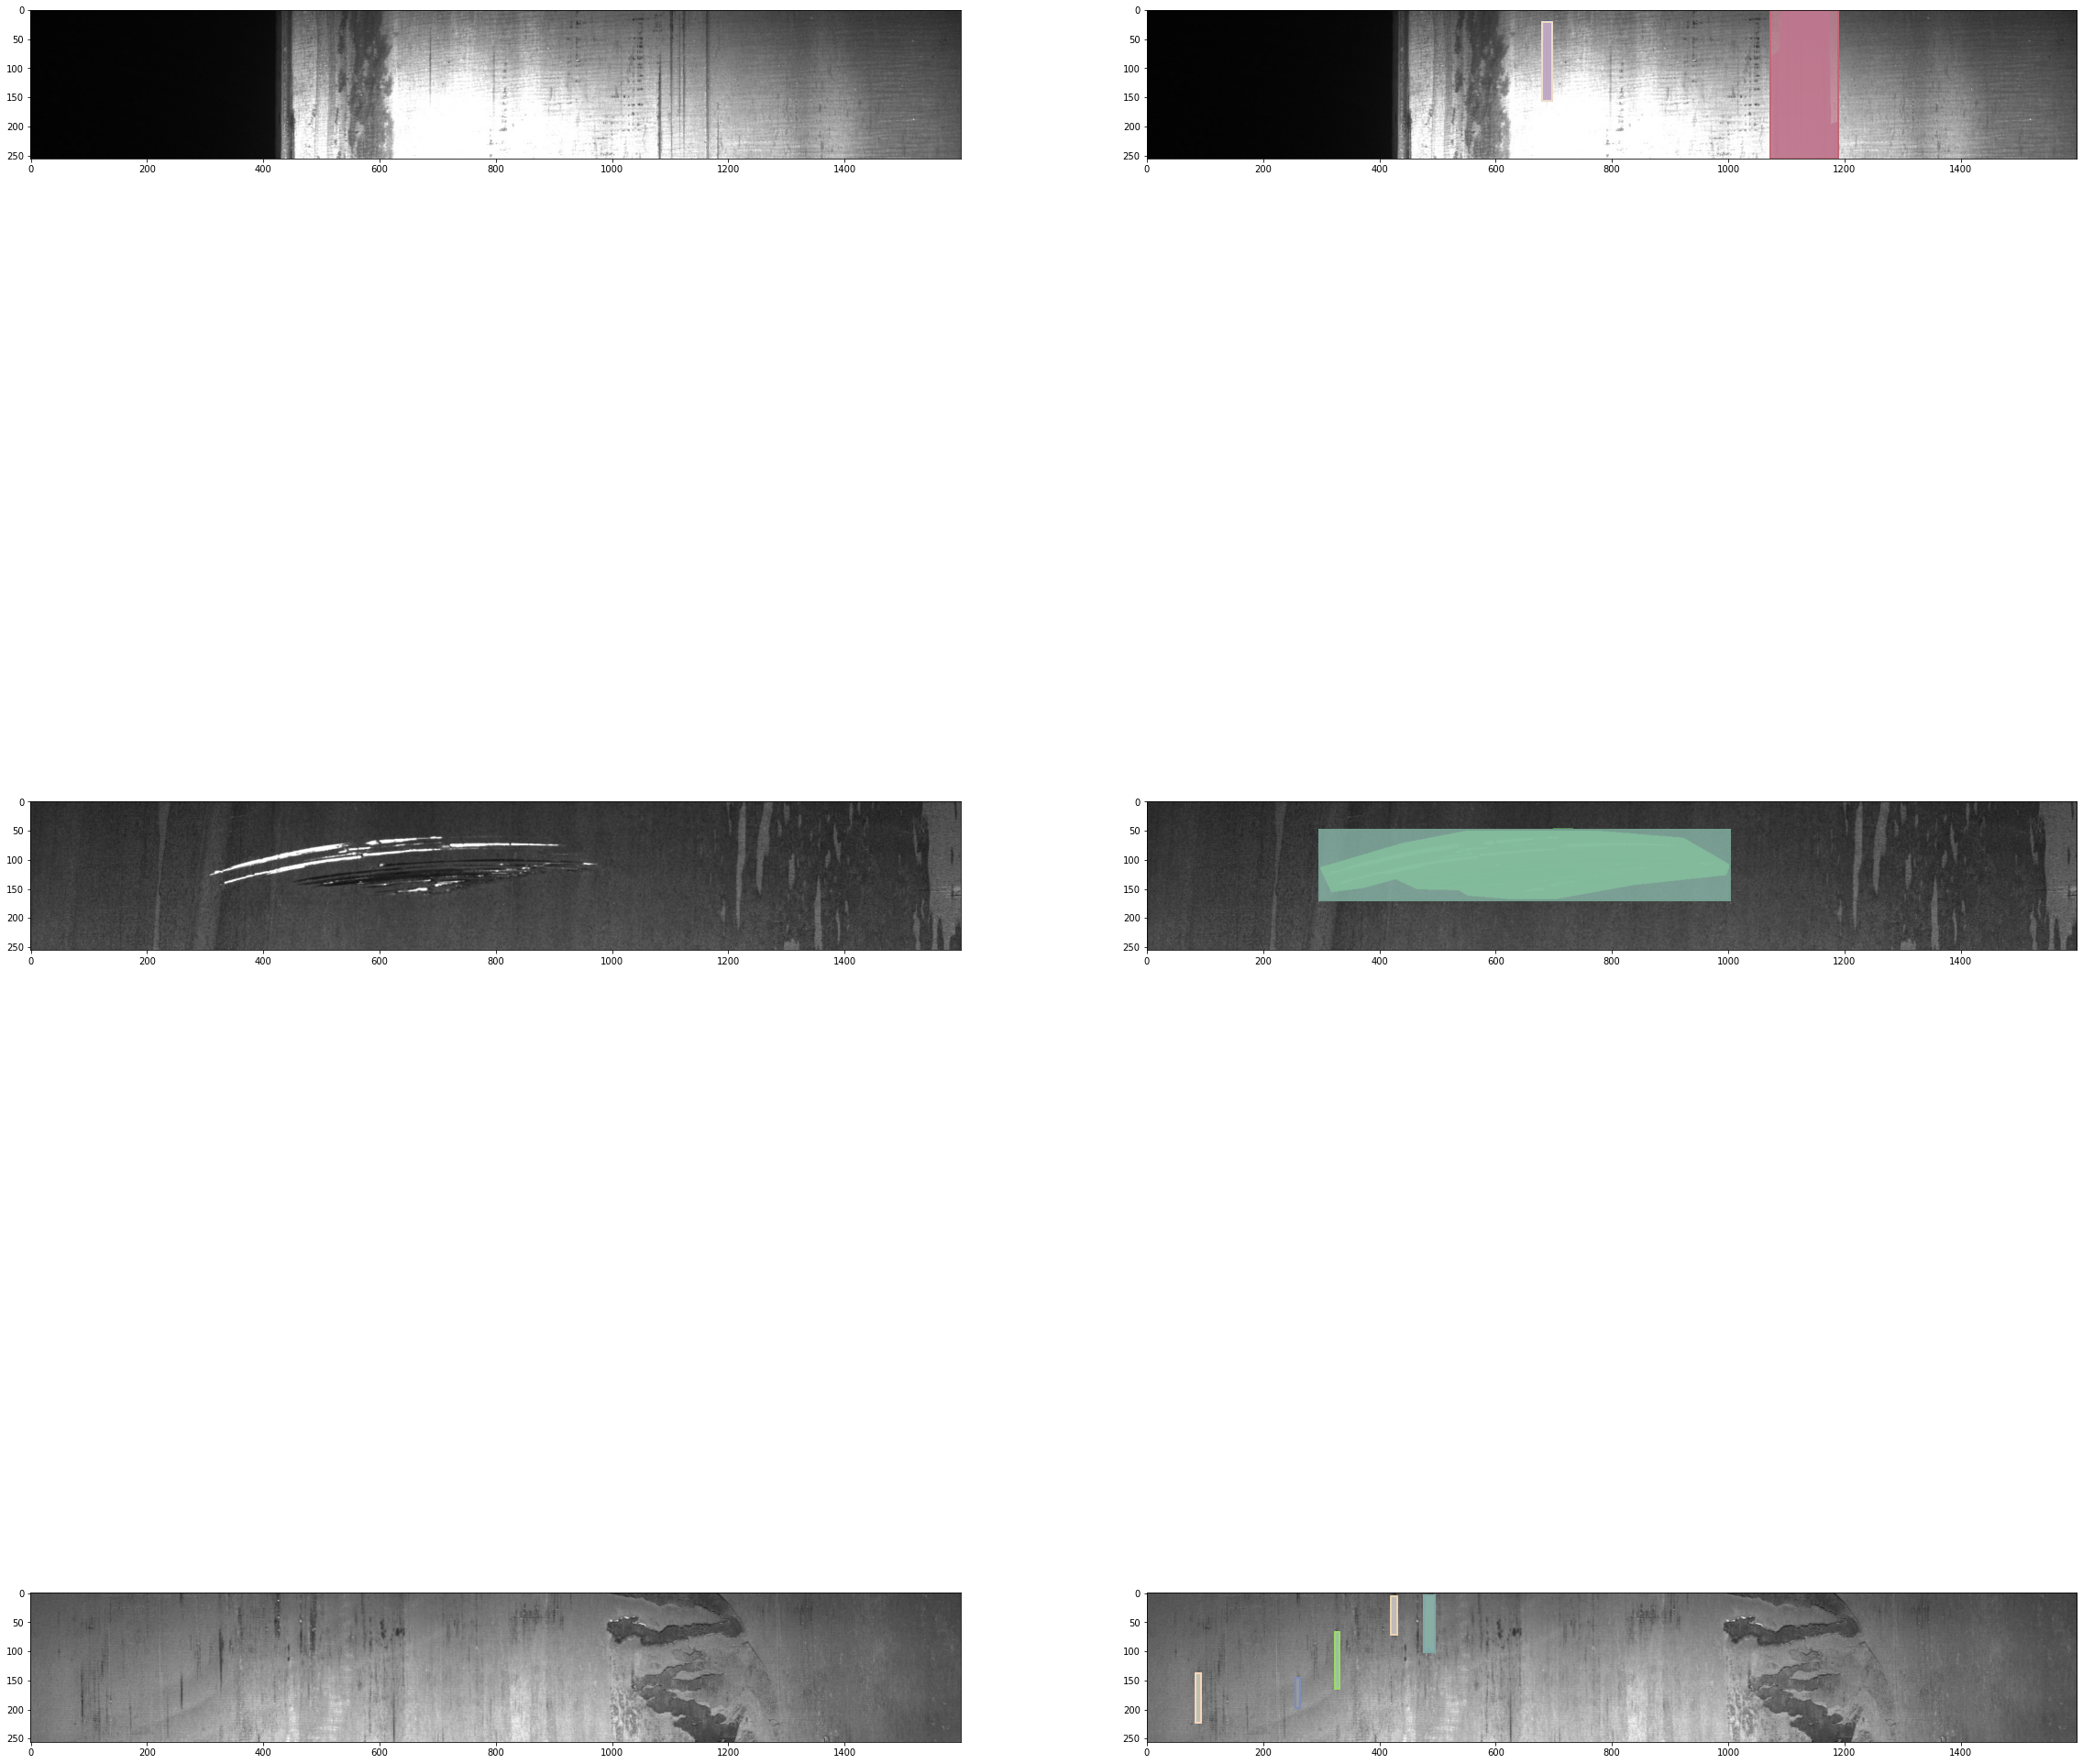

In [77]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

split for training and testing

In [7]:
# neural network wizardry
import tensorflow as tf
import random as rn
# for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

/data/lmp/anaconda3/envs/siamese-mask-rcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/lmp/anaconda3/envs/siamese-mask-rcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/lmp/anaconda3/envs/siamese-mask-rcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/lmp/anaconda3/en

In [18]:
id = df.drop_duplicates(subset = "ImageId")
id.shape

(6666, 3)

In [19]:
from sklearn.model_selection import train_test_split

# stratified split to maintain the same class balance in both sets
train, validate = train_test_split(id, test_size=0.2, random_state=RANDOM_SEED)



In [20]:
train.shape

(5332, 3)

In [21]:
validate.shape

(1334, 3)

In [22]:
val, test = train_test_split(validate, test_size=0.5, random_state=RANDOM_SEED)

In [23]:
val.shape

(667, 3)

In [24]:
test.shape

(667, 3)

In [25]:
train26= df[df.ImageId.isin(train.ImageId)]

In [26]:
test26 = df[df.ImageId.isin(test.ImageId)]

In [27]:
val26 = df[df.ImageId.isin(val.ImageId)]

In [31]:
test26.to_csv('test26.csv',index=False)

In [32]:
train26.to_csv('train26.csv',index=False)

In [33]:
val26.to_csv('val26.csv',index=False)

In [38]:
train_json = create_coco_format_json(train, classes, filepaths_train)

  0%|          | 0/43973 [00:00<?, ?it/s]


IndexError: single positional indexer is out-of-bounds

https://www.geeksforgeeks.org/python-shutil-copyfile-method/?ref=lbp

In [44]:
tr = pd.read_csv('/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection/train26.csv')
tr.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [45]:
va = pd.read_csv('/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection/val26.csv')
va.head()

,ImageId,ClassId,EncodedPixels
0,008d0f87b.jpg,3,72425 21 72641 61 72856 102 73071 142 73287 18...
1,0095cd374.jpg,3,10674 18 10926 48 11178 52 11430 56 11682 60 1...
2,0167a740e.jpg,1,231169 26 231425 85 231681 103 231937 117 2321...
3,017c828a1.jpg,1,246414 3 246557 29 246665 9 246800 54 246916 1...
4,01fd320c9.jpg,3,142290 2 142544 4 142797 7 143051 9 143305 11 ...


In [46]:
ts = pd.read_csv('/data/lmp/code/siamese-mask-rcnn/data/severstal-steel-defect-detection/test26.csv')
ts.head()

,ImageId,ClassId,EncodedPixels
0,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
1,0088260da.jpg,3,26044 13 26283 40 26522 67 26762 92 27001 119 ...
2,00af2671f.jpg,3,155585 64 155713 5542 161281 179 161537 128 16...
3,00cdb56a0.jpg,3,264776 4 265032 12 265288 20 265544 28 265800 ...
4,00ec97699.jpg,3,282768 5 283024 14 283279 24 283535 34 283791 ...


In [35]:
from shutil import copyfile

In [39]:
# Populate training and testing datasets:
for img in train26['ImageId'].unique().tolist():
    source = 'data/severstal-steel-defect-detection/train_images/' + img
    destination = 'data/severstal-steel-defect-detection/train26/' + img
    copyfile(source, destination)


In [29]:
len(ts['ImageId'].unique())

708